# Contents:
- [1. Import Libraries & Data](#import-libraries)
- [2. Data Preprocessing](#data-preprocessing)
- [3. Models Experiments](#models)
    - [3.1 All Features](#All-Features)
    - [3.2 Feature-Selection](#Feature-Selection)
    - [3.3 Feature Selection using PCA](#Feature-Selection-PCA)
- [4. Hyperparameter Tuning](#Hyperparameter-Tuning)
- [5. ANN](#ann)

<a id="import-libraries"></a>
# 1. Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#warnings.filterwarnings('ignore')

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# models 
from sklearn.linear_model import LinearRegression
from sklearn. linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# evaluation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [2]:
data = pd.read_csv('../../data/processed/trial5.csv')

In [3]:
data.head(2)

,logkpl,ALogP,ALogp2,AMR,apol,nAcid,naAromAtom,nAromBond,nAtom,ATSc1,...,MW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,-2.25,1.4570,2.122849,35.0768,17.399965,0,6,6,15,0.112611,...,139.109037,19.385708,1.938571,10.344796,7.326862,3.017933,120.0,11.0,1.508,46.0
1,-2.95,3.6304,13.179804,49.4776,32.539860,1,0,0,32,0.191857,...,172.264984,22.661828,1.888486,4.763098,4.763098,0.000000,277.0,9.0,4.156,44.0


In [4]:
data.shape

(450, 223)

In [5]:
# no missing values
data.isna().sum().sum()

0

<a id="data-preprocessing"></a>
# 2. Data Preprocessing

In [5]:
model_data = data.copy()

In [9]:
X = model_data.drop(["logkpl"], axis=1)
y = model_data['logkpl']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

Shape of X_train: (337, 222) 	 Shape of y_train: (337,)
Shape of X_test: (113, 222) 	 Shape of y_test: (113,)


<a id="models"></a>
# 3. Models Experiments

In [11]:
def plot_feature_importance(model, cols, model_name, slice=20):
    importances = model.feature_importances_
    feature_names = cols#X.columns#selected_features_X.columns #

    # Create a pandas DataFrame with the feature importances
    df = pd.DataFrame({"feature": feature_names, "importance": importances})

    # Sort the DataFrame by importance score
    df = df.sort_values("importance", ascending=False).reset_index(drop=True)

    # Create a bar plot using Seaborn
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.barplot(x="importance", y="feature", data=df[:slice])
    plt.title("Top 20 Feature Importances {}".format(model_name))
    plt.ylabel("Feature Name")
    plt.xlabel("Importance")
    plt.show()

<a id="All-Features"></a>
### 3.1 All Features

In [9]:
def evaluate_model(model_df, i, model_name, model, X, y, X_test, y_test):
    """
    this function is for regression takes the model with the data and calculate
    the scores, with cross validation techniques, in addition to MAE, MSE, RMSE, MAPE
    R Squared and Adjusted R Squared

    :param model: model
    :param X_train, X_test, y_train, y_test: data that was used
    """

    # cross validation with 5 folds
    all_cv_5 = cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_percentage_error")
    print("all CV 5: {}".format(all_cv_5))
    # print("Mean Cross-Validation score: {}".format(all_cv_5.mean()))

    # predictions from our model
    predictions = model.predict(X_test)


    # calculating R squared and Adjusted R squared
    r_sqre = r2_score(y_test, predictions)
    n = len(y_test)
    p = X_test.shape[1] # number of independant features

    Adj_r2 = 1 - ((1 - r_sqre) * (n - 1) / (n - 1 - p))
    
    test_mae = mean_absolute_error(y_test, predictions)

    test_mse = mean_squared_error(y_test, predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, predictions))

    


    print("=" * 40)
    model_df.loc[i] = [model_name, all_cv_5.mean(),
                    test_mae, mean_absolute_percentage_error(y_test, predictions),
                   test_mse, test_rmse, r_sqre, Adj_r2]

    return model_df

In [13]:
# Building pipelins of standard scaler and model for varios regressors.

lasso = Lasso()

dt = DecisionTreeRegressor()

rf = RandomForestRegressor()

kn = KNeighborsRegressor()

xgb = XGBRegressor()

gbr = GradientBoostingRegressor()

eln = ElasticNet()

br = BayesianRidge()

cat = CatBoostRegressor(allow_writing_files=False, verbose=0, task_type="GPU")

lgbm = LGBMRegressor()



# List of all the pipelines
pipelines = [lasso, dt, rf, kn, xgb, gbr,
            eln, br, cat, lgbm] # 

# Dictionary of pipelines and model types for ease of reference
ml_dict = {0: "Lasso", 1: "DecisionTree", 2: "RandomForest", 3: "KNeighbors", 4: "XGBRegressor", 5: "GradientBoostingRegressor",
                6: "Elastic Net", 7:"BayesianRidge", 8: "CatBoostRegressor", 9: "LGBMRegressor"}
    #, 

models_scores_df = pd.DataFrame(columns=["model", "Mean CV", "MAE",
                                         "MAPE", "MSE", "RMSE", "R_Squared", "Adjusted_R_Squared"])



# Fit the pipelines and display the scores with Cross validation
for i, pipe in enumerate(pipelines):
    # getting the name of our model
    model_name = ml_dict[i]
    print(model_name)
    
    # fitting our data
    pipe.fit(X_train, y_train)
    
    evaluate_model(models_scores_df, i, model_name, pipe, X, y, X_test, y_test)

Lasso
all CV 5: [-0.65669447 -0.42822352 -0.29086271 -0.2503494  -0.41980392]
DecisionTree


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.452e+00, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.760e-01, tolerance: 3.921e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

all CV 5: [-0.3659781  -0.24722002 -0.14967961 -0.32846894 -0.26559863]
RandomForest
all CV 5: [-0.39137599 -0.21461692 -0.17524115 -0.25717151 -0.17039366]
KNeighbors
all CV 5: [-0.97429248 -0.26609678 -0.29111065 -0.39448243 -0.39146768]
XGBRegressor
all CV 5: [-0.38190885 -0.22865999 -0.20061457 -0.25882115 -0.17804088]
GradientBoostingRegressor
all CV 5: [-0.39218119 -0.21323253 -0.15728282 -0.23735503 -0.18049778]
Elastic Net
all CV 5: [-0.61827594 -0.42422348 -0.29368641 -0.25495005 -0.38786222]
BayesianRidge


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.884e+00, tolerance: 4.524e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.392e+01, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

all CV 5: [-0.47628856 -0.30833632 -0.1643075  -0.23702072 -0.38632651]
CatBoostRegressor
all CV 5: [-0.37426747 -0.21255177 -0.19388375 -0.24364443 -0.21217029]
LGBMRegressor
all CV 5: [-0.38100898 -0.22143636 -0.19730733 -0.2862149  -0.17249157]


In [14]:
models_scores_df

,model,Mean CV,MAE,MAPE,MSE,RMSE,R_Squared,Adjusted_R_Squared
0,Lasso,-0.409187,0.973427,0.743351,1.354955,1.164025,-0.001015,2.019216
1,DecisionTree,-0.271389,0.504424,0.334530,0.501565,0.708212,0.629453,1.377284
2,RandomForest,-0.241760,0.471280,0.389598,0.425321,0.652166,0.685781,1.319932
3,KNeighbors,-0.463490,0.516779,0.444903,0.516549,0.718714,0.618383,1.388555
4,XGBRegressor,-0.249609,0.490577,0.364403,0.464589,0.681608,0.656770,1.349470
5,GradientBoostingRegressor,-0.236110,0.471689,0.408264,0.437466,0.661412,0.676808,1.329068
6,Elastic Net,-0.395800,0.904793,0.700403,1.163201,1.078518,0.140648,1.874976
7,BayesianRidge,-0.314456,0.506074,0.401861,0.533027,0.730087,0.606209,1.400950
8,CatBoostRegressor,-0.247304,0.478245,0.403230,0.447752,0.669143,0.669209,1.336805
9,LGBMRegressor,-0.251692,0.473802,0.396605,0.457187,0.676156,0.662239,1.343902


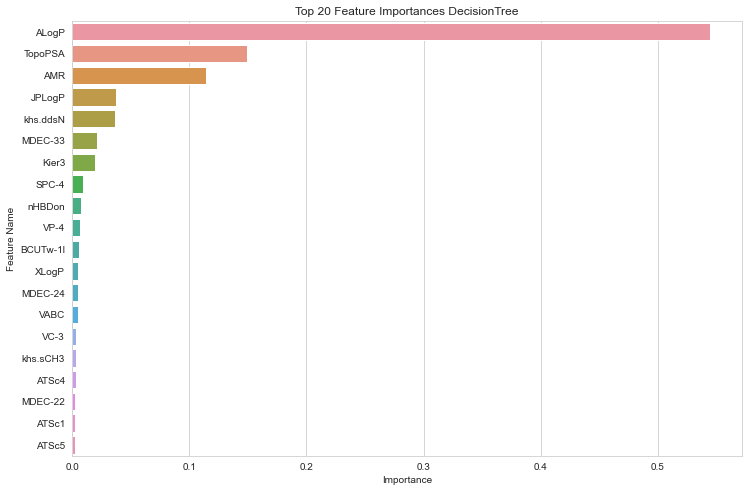

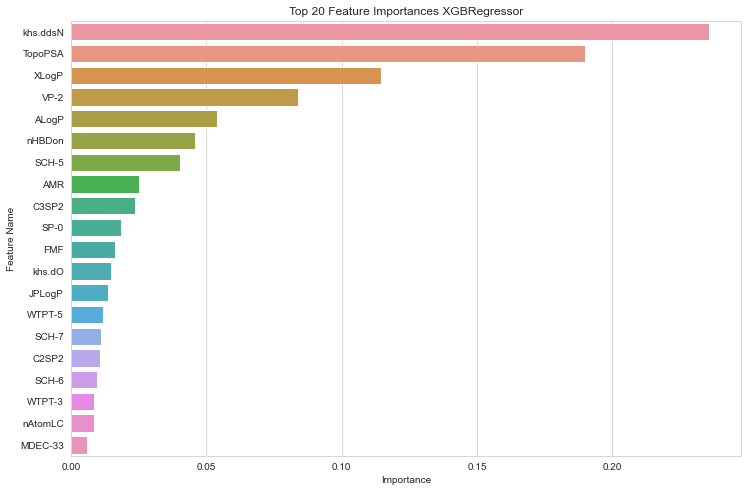

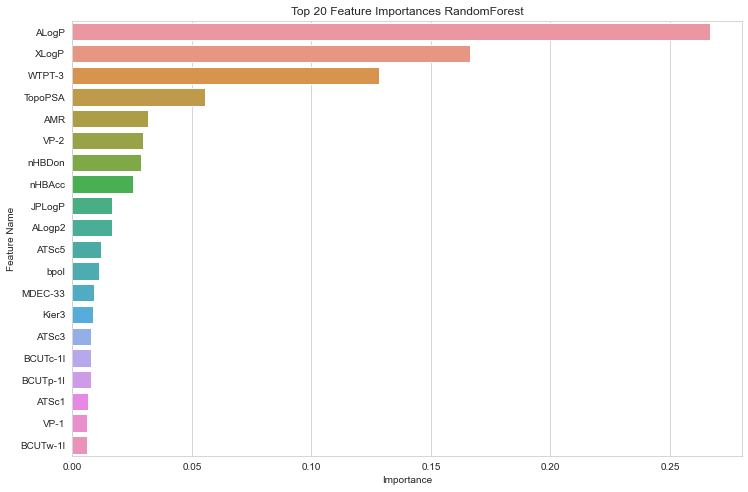

In [15]:
metric = "MAPE"

# selecting top 3 score based on metric
filtered_models_scores_df =  models_scores_df.sort_values(metric).iloc[:3, :]

for i in filtered_models_scores_df.index:
    plot_feature_importance(pipelines[i],  X.columns, ml_dict[i])

<a id="Feature-Selection"></a>
### 3.2 Feature Selection

In [16]:
import statsmodels.api as sm
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [17]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(GradientBoostingRegressor(), 
           k_features=15,
           forward=True, 
           floating=False, 
           verbose=0,
           scoring="neg_mean_absolute_percentage_error",
           cv=0)

sfs1 = sfs1.fit(X, y)

In [18]:
# try selecting more features
sfs1.k_feature_names_

('nAtom',
 'ATSc3',
 'ATSc4',
 'ATSm5',
 'ATSp5',
 'BCUTp-1l',
 'SCH-7',
 'VC-6',
 'VP-4',
 'VP-6',
 'FMF',
 'JPLogP',
 'MDEC-12',
 'TopoPSA',
 'XLogP')

In [19]:
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(77,)",[-0.20010936681143557],-0.200109,"(VP-4,)",NaN,0.0,NaN
2,"(77, 209)",[-0.15591571330861745],-0.155916,"(VP-4, TopoPSA)",NaN,0.0,NaN
3,"(11, 77, 209)",[-0.14595456454650726],-0.145955,"(ATSc4, VP-4, TopoPSA)",NaN,0.0,NaN
4,"(11, 77, 209, 220)",[-0.14275823637857807],-0.142758,"(ATSc4, VP-4, TopoPSA, XLogP)",NaN,0.0,NaN
5,"(11, 77, 79, 209, 220)",[-0.13841826267534427],-0.138418,"(ATSc4, VP-4, VP-6, TopoPSA, XLogP)",NaN,0.0,NaN
6,"(10, 11, 77, 79, 209, 220)",[-0.13764980640131905],-0.13765,"(ATSc3, ATSc4, VP-4, VP-6, TopoPSA, XLogP)",NaN,0.0,NaN
7,"(10, 11, 27, 77, 79, 209, 220)",[-0.13497015931569553],-0.13497,"(ATSc3, ATSc4, BCUTp-1l, VP-4, VP-6, TopoPSA, ...",NaN,0.0,NaN
8,"(10, 11, 27, 77, 79, 88, 209, 220)",[-0.13128494025202264],-0.131285,"(ATSc3, ATSc4, BCUTp-1l, VP-4, VP-6, JPLogP, T...",NaN,0.0,NaN
9,"(10, 11, 27, 77, 79, 88, 175, 209, 220)",[-0.1301085265214019],-0.130109,"(ATSc3, ATSc4, BCUTp-1l, VP-4, VP-6, JPLogP, M...",NaN,0.0,NaN
10,"(10, 11, 27, 77, 79, 82, 88, 175, 209, 220)",[-0.12939687333513109],-0.129397,"(ATSc3, ATSc4, BCUTp-1l, VP-4, VP-6, FMF, JPLo...",NaN,0.0,NaN


In [20]:
selected_features_X = X.iloc[:, list(sfs1.k_feature_idx_)]
y = model_data['logkpl']

X_train, X_test, y_train, y_test = train_test_split(selected_features_X, y, test_size=0.25)

print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

Shape of X_train: (337, 15) 	 Shape of y_train: (337,)
Shape of X_test: (113, 15) 	 Shape of y_test: (113,)


In [21]:
# Building pipelins of standard scaler and model for varios regressors.

lasso = Lasso()

dt = DecisionTreeRegressor()

rf = RandomForestRegressor()

kn = KNeighborsRegressor()

xgb = XGBRegressor()

gbr = GradientBoostingRegressor()

eln = ElasticNet()

br = BayesianRidge()

cat = CatBoostRegressor(allow_writing_files=False, verbose=0, task_type="GPU")

lgbm = LGBMRegressor()



# List of all the pipelines
pipelines = [lasso, dt, rf, kn, xgb, gbr,
            eln, br, cat, lgbm] # 

# Dictionary of pipelines and model types for ease of reference
ml_dict = {0: "Lasso", 1: "DecisionTree", 2: "RandomForest", 3: "KNeighbors", 4: "XGBRegressor", 5: "GradientBoostingRegressor",
                6: "Elastic Net", 7:"BayesianRidge", 8: "CatBoostRegressor", 9: "LGBMRegressor"}
    #, 

models_scores_df = pd.DataFrame(columns=["model", "Mean CV", "MAE",
                                         "MAPE", "MSE", "RMSE", "R_Squared", "Adjusted_R_Squared"])



# Fit the pipelines and display the scores with Cross validation
for i, pipe in enumerate(pipelines):
    # getting the name of our model
    model_name = ml_dict[i]
    print(model_name)
    
    # fitting our data
    pipe.fit(X_train, y_train)
    
    evaluate_model(models_scores_df, i, model_name, pipe, X, y, X_test, y_test)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.452e+00, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.760e-01, tolerance: 3.921e-02
  model = cd_fast.enet_coordinate_descent(


Lasso
all CV 5: [-0.65669447 -0.42822352 -0.29086271 -0.2503494  -0.41980392]
DecisionTree


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e-01, tolerance: 4.703e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.702e-01, tolerance: 4.572e-02
  model = cd_fast.enet_coordinate_descent(


all CV 5: [-0.49926738 -0.24580522 -0.1608406  -0.3285795  -0.26075415]
RandomForest
all CV 5: [-0.3906352  -0.21396153 -0.17978436 -0.27138523 -0.17707675]
KNeighbors
all CV 5: [-0.97429248 -0.26609678 -0.29111065 -0.39448243 -0.39146768]
XGBRegressor
all CV 5: [-0.38190885 -0.22865999 -0.20061457 -0.25882115 -0.17804088]
GradientBoostingRegressor
all CV 5: [-0.38411145 -0.21354966 -0.1576288  -0.2335753  -0.18092858]
Elastic Net
all CV 5: [-0.61827594 -0.42422348 -0.29368641 -0.25495005 -0.38786222]
BayesianRidge


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.884e+00, tolerance: 4.524e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.392e+01, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

all CV 5: [-0.47628856 -0.30833632 -0.1643075  -0.23702072 -0.38632651]
CatBoostRegressor
all CV 5: [-0.37426747 -0.21255177 -0.19388375 -0.24364443 -0.21217029]
LGBMRegressor
all CV 5: [-0.38100898 -0.22143636 -0.19730733 -0.2862149  -0.17249157]


In [22]:
models_scores_df

,model,Mean CV,MAE,MAPE,MSE,RMSE,R_Squared,Adjusted_R_Squared
0,Lasso,-0.409187,0.617055,0.462907,0.621743,0.788507,0.387423,0.292694
1,DecisionTree,-0.299049,0.493251,0.279296,0.619598,0.787146,0.389536,0.295134
2,RandomForest,-0.246569,0.457639,0.311855,0.513135,0.716335,0.494429,0.416248
3,KNeighbors,-0.463490,0.541327,0.432017,0.591262,0.768936,0.417455,0.327370
4,XGBRegressor,-0.249609,0.462143,0.322739,0.556926,0.746275,0.451284,0.366432
5,GradientBoostingRegressor,-0.233959,0.470353,0.318441,0.547089,0.739654,0.460977,0.377623
6,Elastic Net,-0.395800,0.608269,0.459859,0.589752,0.767953,0.418943,0.329088
7,BayesianRidge,-0.314456,0.573846,0.447415,0.510099,0.714212,0.497421,0.419703
8,CatBoostRegressor,-0.247304,0.447615,0.322347,0.469100,0.684908,0.537816,0.466344
9,LGBMRegressor,-0.251692,0.463001,0.347484,0.513074,0.716292,0.494489,0.416318


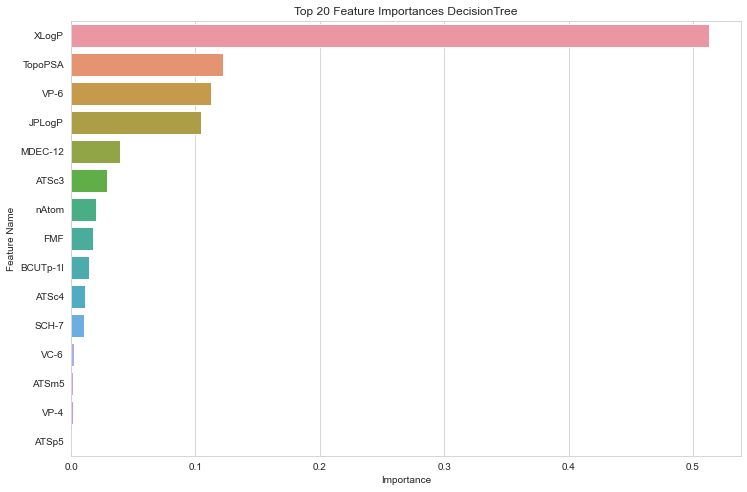

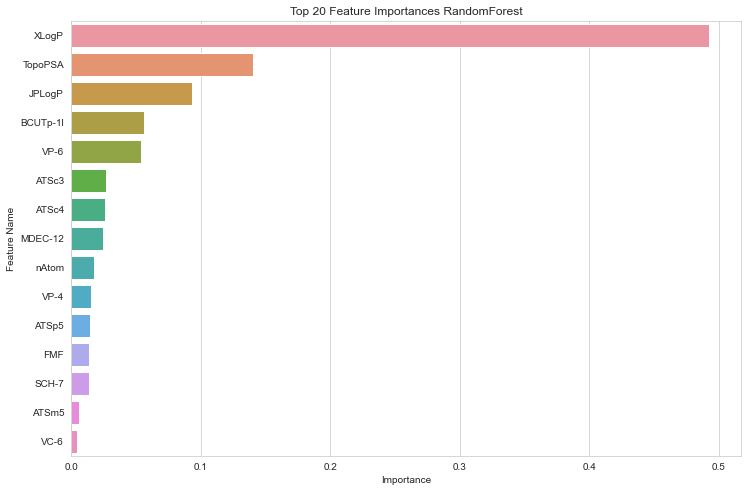

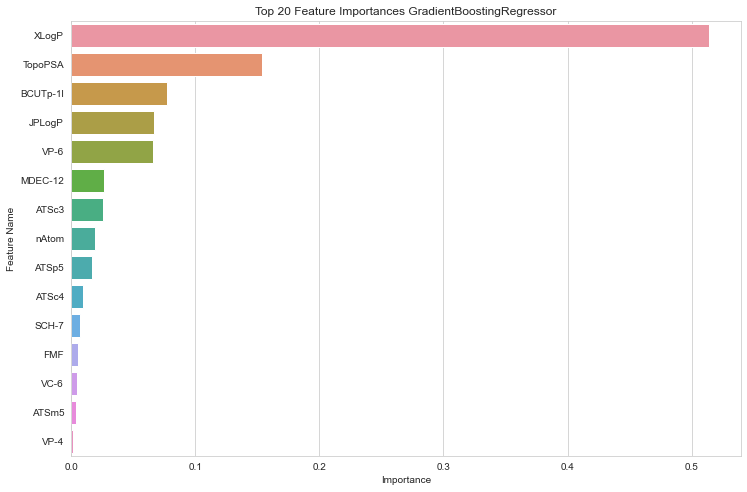

In [23]:
metric = "MAPE"

# selecting top 3 score based on metric
filtered_models_scores_df =  models_scores_df.sort_values(metric).iloc[:3, :]

for i in filtered_models_scores_df.index:
    plot_feature_importance(pipelines[i],  sfs1.k_feature_names_, ml_dict[i])

In [24]:
calc_vif(selected_features_X)

,variables,VIF
0,nAtom,131.890992
1,ATSc3,6.296528
2,ATSc4,4.628750
3,ATSm5,132.665400
4,ATSp5,200.105858
5,BCUTp-1l,33.861533
6,SCH-7,49.246722
7,VC-6,18.231877
8,VP-4,1187.995026
9,VP-6,846.353572


<a id="Feature-Selection-PCA"></a>
### 3.3 Feature Selection using PCA

In [10]:
X = model_data.drop(["logkpl"], axis=1)
y = model_data['logkpl']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA


# initilizing and fitting the pca
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_scaled)

print("Number of Components by PCA", X_pca.shape[1])
print("Explained Variance Ratio", pca.explained_variance_ratio_.sum())

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25)

print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

Number of Components by PCA 35
Explained Variance Ratio 0.9906110103659235
Shape of X_train: (337, 35) 	 Shape of y_train: (337,)
Shape of X_test: (113, 35) 	 Shape of y_test: (113,)


In [11]:
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X.columns

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))
df

,0,1
0,PC1,ATSp2
1,PC10,khs.aasN
2,PC11,C1SP1
3,PC12,khs.ssNH
4,PC13,khs.sBr
5,PC14,khs.aaS
6,PC15,khs.dS
7,PC16,khs.ddssS
8,PC17,khs.sCl
9,PC18,khs.dS


In [12]:
# Building pipelins of standard scaler and model for varios regressors.

lasso = Lasso()

dt = DecisionTreeRegressor()

rf = RandomForestRegressor()

kn = KNeighborsRegressor()

xgb = XGBRegressor()

gbr = GradientBoostingRegressor()

eln = ElasticNet()

br = BayesianRidge()

cat = CatBoostRegressor(allow_writing_files=False, verbose=0, task_type="GPU")

lgbm = LGBMRegressor()



# List of all the pipelines
pipelines = [lasso, dt, rf, kn, xgb, gbr,
            eln, br, cat, lgbm] # 

# Dictionary of pipelines and model types for ease of reference
ml_dict = {0: "Lasso", 1: "DecisionTree", 2: "RandomForest", 3: "KNeighbors", 4: "XGBRegressor", 5: "GradientBoostingRegressor",
                6: "Elastic Net", 7:"BayesianRidge", 8: "CatBoostRegressor", 9: "LGBMRegressor"}
    #, 

models_scores_df = pd.DataFrame(columns=["model", "Mean CV", "MAE",
                                         "MAPE", "MSE", "RMSE", "R_Squared", "Adjusted_R_Squared"])



# Fit the pipelines and display the scores with Cross validation
for i, pipe in enumerate(pipelines):
    # getting the name of our model
    model_name = ml_dict[i]
    print(model_name)
    
    # fitting our data
    pipe.fit(X_train, y_train)
    
    evaluate_model(models_scores_df, i, model_name, pipe, X, y, X_test, y_test)

Lasso
all CV 5: [-0.65669447 -0.42822352 -0.29086271 -0.2503494  -0.41980392]
DecisionTree


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.452e+00, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.760e-01, tolerance: 3.921e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

all CV 5: [-0.49270224 -0.25104739 -0.14989317 -0.33466418 -0.27695662]
RandomForest
all CV 5: [-0.41649855 -0.21848115 -0.17663578 -0.25207254 -0.17961095]
KNeighbors
all CV 5: [-0.97429248 -0.26609678 -0.29111065 -0.39448243 -0.39146768]
XGBRegressor
all CV 5: [-0.38190885 -0.22865999 -0.20061457 -0.25882115 -0.17804088]
GradientBoostingRegressor
all CV 5: [-0.38892355 -0.21597575 -0.15739477 -0.23474844 -0.1734318 ]
Elastic Net
all CV 5: [-0.61827594 -0.42422348 -0.29368641 -0.25495005 -0.38786222]
BayesianRidge


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.884e+00, tolerance: 4.524e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.392e+01, tolerance: 5.008e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

all CV 5: [-0.47628856 -0.30833632 -0.1643075  -0.23702072 -0.38632651]
CatBoostRegressor
all CV 5: [-0.37426747 -0.21255177 -0.19388375 -0.24364443 -0.21217029]
LGBMRegressor
all CV 5: [-0.38100898 -0.22143636 -0.19730733 -0.2862149  -0.17249157]


In [13]:
models_scores_df

,model,Mean CV,MAE,MAPE,MSE,RMSE,R_Squared,Adjusted_R_Squared
0,Lasso,-0.409187,0.858395,0.356338,1.118837,1.057751,0.206308,-0.154461
1,DecisionTree,-0.301053,0.525019,0.205309,0.665914,0.816035,0.527607,0.312883
2,RandomForest,-0.248660,0.460675,0.181832,0.464693,0.681684,0.670351,0.520511
3,KNeighbors,-0.463490,0.530796,0.198991,0.519649,0.720867,0.631366,0.463805
4,XGBRegressor,-0.249609,0.471045,0.184675,0.568272,0.753838,0.596874,0.413635
5,GradientBoostingRegressor,-0.234095,0.482734,0.186918,0.530627,0.728442,0.623579,0.452478
6,Elastic Net,-0.395800,0.805412,0.334128,0.953490,0.976468,0.323603,0.016150
7,BayesianRidge,-0.314456,0.548133,0.223064,0.574952,0.758256,0.592135,0.406741
8,CatBoostRegressor,-0.247304,0.453269,0.175637,0.454796,0.674386,0.677372,0.530723
9,LGBMRegressor,-0.251692,0.457987,0.179667,0.457147,0.676126,0.675705,0.528298


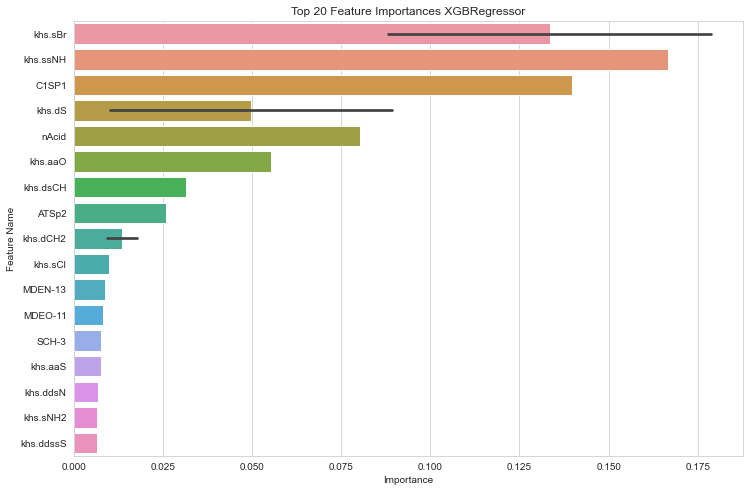

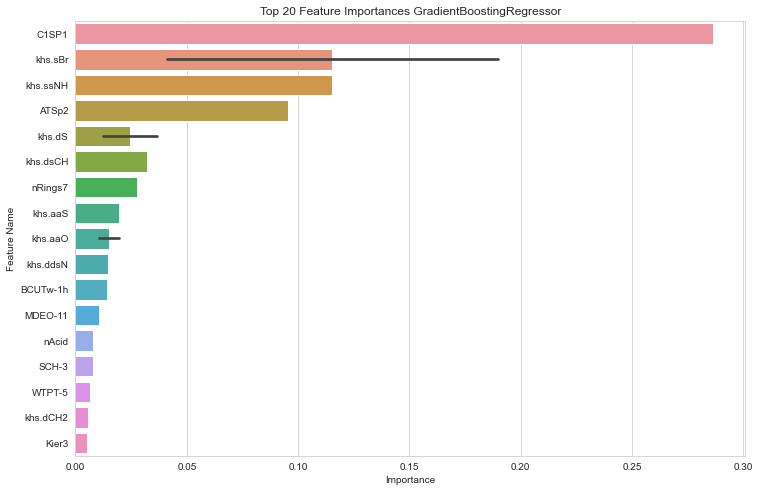

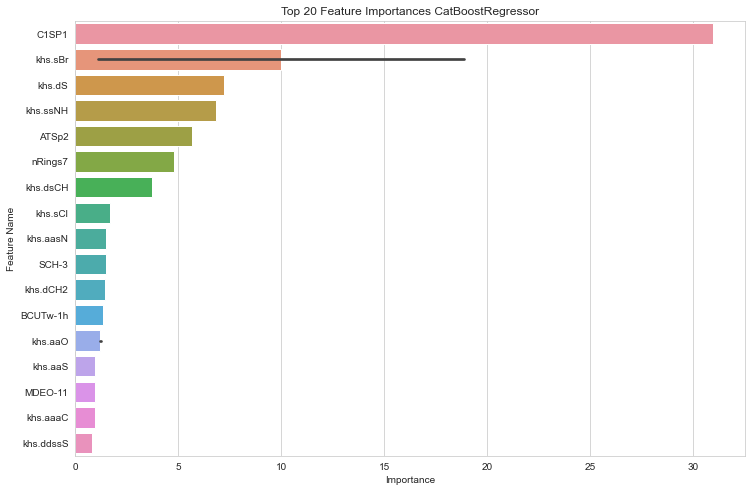

In [29]:
metric = "MAPE"

# selecting top 3 score based on metric
filtered_models_scores_df =  models_scores_df.sort_values(metric).iloc[:3, :]

for i in filtered_models_scores_df.index:
    plot_feature_importance(pipelines[i],  df[1].values, ml_dict[i])

<a id="Hyperparameter-Tuning"></a>
# 4. Hyperparameter Tuning

In [30]:
GBR = GradientBoostingRegressor()

parameters = {'learning_rate': [0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05],
                'subsample'    : [0.9, 0.5, 0.2, 0.1],
                'n_estimators' : [100,500,1000, 1500],
                'max_depth'    : [4,6,8,10]
                }

grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv=5, n_jobs=-1, scoring="neg_mean_absolute_percentage_error")
grid_GBR.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=1500,
                          subsample=0.1)

 The best score across ALL searched params:
 -0.24707300241409316

 The best parameters across ALL searched params:
 {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 1500, 'subsample': 0.1}


In [31]:
LGBM = LGBMRegressor()

parameters = {'n_estimators' : [100,500,1000, 1500],
                'max_depth'    : [4,6,8,10],
                'learning_rate': [0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05],
            }

grid_LGBM = GridSearchCV(estimator=LGBM, param_grid=parameters, cv=5, n_jobs=-1, scoring="neg_mean_absolute_percentage_error")
grid_LGBM.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_LGBM.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_LGBM.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_LGBM.best_params_)


 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.02, max_depth=4, n_estimators=500)

 The best score across ALL searched params:
 -0.25277640330976203

 The best parameters across ALL searched params:
 {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 500}


In [32]:
XGB = XGBRegressor()

parameters = {
        'min_child_weight': [1, 5, 10], #50, 100
        'gamma': [0.5, 1, 2], #1.5 5
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 6, 9], # 4, 5, 8, 10
        'learning_rate': [0.001, 0.05, 0.01, 0.15],  # 0.2 0.001
        'n_estimators': [100, 500, 500] # 300 1000
        }

grid_XGB = GridSearchCV(estimator=XGB, param_grid=parameters, cv=5, n_jobs=-1, scoring="neg_mean_absolute_percentage_error")
grid_XGB.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_XGB.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_XGB.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_XGB.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

 The best score across ALL searched params:
 -0.2409843778459378

 The best parameters across ALL searched params:
 {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.15, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 50

<a id="ann"></a>
# 5. ANN

In [39]:
X = model_data.drop(["logkpl"], axis=1)
y = model_data['logkpl']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

In [46]:
import tensorflow as tf

model = tf.keras.Sequential([

tf.keras.layers.Dense(256, input_shape=[X.shape[1]]),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(128),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(64),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(32),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(8),
tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss="mean_absolute_error")

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               57088     
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)               

In [48]:
history = model.fit(X_train, y_train, epochs=4000, validation_data=(X_test, y_test), verbose=2)

Epoch 1/4000
11/11 - 0s - loss: 3.1902 - val_loss: 2.5127 - 348ms/epoch - 32ms/step
Epoch 2/4000
11/11 - 0s - loss: 2.9785 - val_loss: 2.5372 - 29ms/epoch - 3ms/step
Epoch 3/4000
11/11 - 0s - loss: 2.8674 - val_loss: 2.5217 - 30ms/epoch - 3ms/step
Epoch 4/4000
11/11 - 0s - loss: 2.9927 - val_loss: 2.5152 - 31ms/epoch - 3ms/step
Epoch 5/4000
11/11 - 0s - loss: 2.7865 - val_loss: 2.5299 - 31ms/epoch - 3ms/step
Epoch 6/4000
11/11 - 0s - loss: 2.7026 - val_loss: 2.5278 - 30ms/epoch - 3ms/step
Epoch 7/4000
11/11 - 0s - loss: 2.6984 - val_loss: 2.5651 - 31ms/epoch - 3ms/step
Epoch 8/4000
11/11 - 0s - loss: 2.6863 - val_loss: 2.5239 - 31ms/epoch - 3ms/step
Epoch 9/4000
11/11 - 0s - loss: 2.5767 - val_loss: 2.5052 - 31ms/epoch - 3ms/step
Epoch 10/4000
11/11 - 0s - loss: 2.5320 - val_loss: 2.5118 - 30ms/epoch - 3ms/step
Epoch 11/4000
11/11 - 0s - loss: 2.3739 - val_loss: 2.5197 - 30ms/epoch - 3ms/step
Epoch 12/4000
11/11 - 0s - loss: 2.4461 - val_loss: 2.5135 - 30ms/epoch - 3ms/step
Epoch 13/40

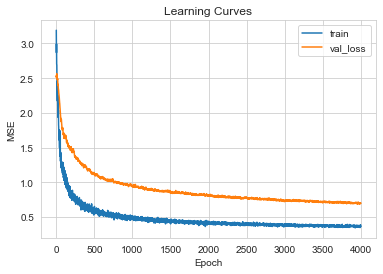

In [49]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [51]:
predictions = model.predict(X_test)

# MAE, MSE, RMSE
print("MAE: {}".format(mean_absolute_error(y_test, predictions)))
print("MSE: {}".format(mean_squared_error(y_test, predictions)))
print("RMSE: {}".format(mean_squared_error(y_test, predictions, squared=False)))
print("MAPE: {}".format(mean_absolute_percentage_error(y_test, predictions)))
print("R2: {}".format(r2_score(y_test, predictions)))

4/4 [==============================] - 0s 1000us/step
MAE: 0.7033355321504374
MSE: 4.06069110382713
RMSE: 2.015115655198761
MAPE: 0.4276432991495213
R2: -1.999963220311824
